<a href="https://colab.research.google.com/github/vaibram/AI/blob/main/hackathon_genai_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.image as mpimg
import random

In [ ]:
articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
# customers = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

In [ ]:
item_freq = transactions.groupby('article_id')['customer_id'].nunique()
user_freq = transactions.groupby('customer_id')['article_id'].nunique()

items = item_freq[item_freq >= 100].index
users = user_freq[user_freq >= 100].index

filtered_df = transactions[transactions['article_id'].isin(items) & transactions['customer_id'].isin(users)]

In [ ]:
freq = filtered_df.groupby(['customer_id', 'article_id']).size().reset_index(name='frequency')

GraphTravel_HM = filtered_df.merge(freq, on=['customer_id', 'article_id'], how='left')

GraphTravel_HM = GraphTravel_HM[GraphTravel_HM['frequency'] >= 10]

In [ ]:
display(GraphTravel_HM)

print("unique customer_id" , GraphTravel_HM.customer_id.nunique())
print("unique article_id" , GraphTravel_HM.article_id.nunique())

,t_dat,customer_id,article_id,price,sales_channel_id,frequency
194,2018-09-20,06636eaa476a2f3417e8d11905e17a8066b4c9ae26bc78...,399201022,0.059305,2,12
195,2018-09-20,06636eaa476a2f3417e8d11905e17a8066b4c9ae26bc78...,399201022,0.059305,2,12
196,2018-09-20,06636eaa476a2f3417e8d11905e17a8066b4c9ae26bc78...,399201022,0.059305,2,12
1181,2018-09-20,1f58e8b3be25c4ca4bb457902f911cfbd4ed3a3f502685...,228257001,0.006763,2,19
1182,2018-09-20,1f58e8b3be25c4ca4bb457902f911cfbd4ed3a3f502685...,228257001,0.006797,2,19
...,...,...,...,...,...,...
6998469,2020-09-22,03fdb0bf2d9ff8ba23e1b4aef53709119aad5bc83691d8...,554450043,0.033881,2,18
6998949,2020-09-22,189a65461f77ed2d1621bb1201e68c4af1cfacf110d08e...,160442010,0.012898,2,11
6998950,2020-09-22,189a65461f77ed2d1621bb1201e68c4af1cfacf110d08e...,160442010,0.012915,2,11
6998951,2020-09-22,189a65461f77ed2d1621bb1201e68c4af1cfacf110d08e...,160442010,0.012898,2,11


unique customer_id 1013
unique article_id 922


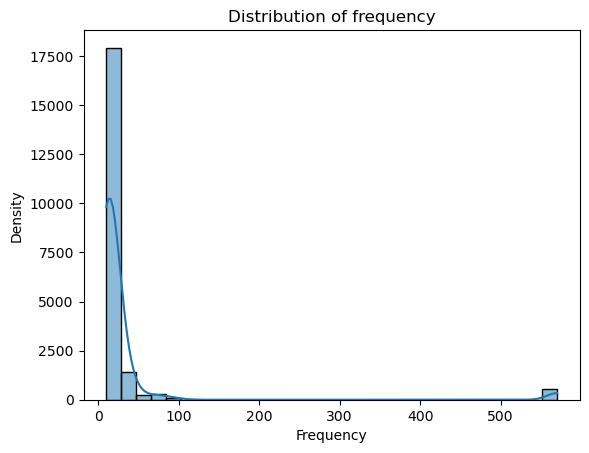

In [ ]:
sns.histplot(GraphTravel_HM['frequency'], kde=True, bins=30)

plt.title('Distribution of frequency')
plt.xlabel('Frequency')
plt.ylabel('Density')

plt.show()

In [ ]:
unique_customer_ids = GraphTravel_HM['customer_id'].unique()
customer_id_mapping = {id: i for i, id in enumerate(unique_customer_ids)}
GraphTravel_HM['customer_id'] = GraphTravel_HM['customer_id'].map(customer_id_mapping)

item_name_mapping = dict(zip(articles['article_id'], articles['prod_name'])) # prod_name

In [ ]:
G = nx.Graph()

for index, row in GraphTravel_HM.iterrows():
    G.add_node(row['customer_id'], type='user')
    G.add_node(row['article_id'], type='item')
    G.add_edge(row['customer_id'], row['article_id'], weight=row['frequency'])

In [ ]:
# biased random walk
def biased_random_walk(G, start_node, walk_length, p=1, q=1):
    walk = [start_node]

    while len(walk) < walk_length:
        cur_node = walk[-1]
        cur_neighbors = list(G.neighbors(cur_node))

        if len(cur_neighbors) > 0:
            if len(walk) == 1:
                walk.append(random.choice(cur_neighbors))
            else:
                prev_node = walk[-2]

                probability = []
                for neighbor in cur_neighbors:
                    if neighbor == prev_node:
                        # Return parameter
                        probability.append(1/p)
                    elif G.has_edge(neighbor, prev_node):
                        # Stay parameter
                        probability.append(1)
                    else:
                        # In-out parameter
                        probability.append(1/q)

                probability = np.array(probability)
                probability = probability / probability.sum()  # normalize

                next_node = np.random.choice(cur_neighbors, p=probability)
                walk.append(next_node)
        else:
            break

    return walk

In [ ]:
def generate_walks(G, num_walks, walk_length, p=1, q=1):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)  # to ensure randomness
        for node in nodes:
            walk_from_node = biased_random_walk(G, node, walk_length, p, q)
            walks.append(walk_from_node)
    return walks

In [ ]:
# Random Walk
walks = generate_walks(G, num_walks=10, walk_length=20, p=9, q=1)
filtered_walks = [walk for walk in walks if len(walk) >= 5]

# to String  (for Word2Vec input)
walks = [[str(node) for node in walk] for walk in walks]

# Word2Vec train
model = Word2Vec(walks, vector_size=128, window=5, min_count=0,  hs=1, sg=1, workers=4, epochs=10)

# node embedding extract
embeddings = {node_id: model.wv[node_id] for node_id in model.wv.index_to_key}

In [ ]:
def get_user_embedding(user_id, embeddings):
    return embeddings[str(user_id)]

In [ ]:
def get_rated_items(user_id, df):
    return set(df[df['customer_id'] == user_id]['article_id'])

In [ ]:
def calculate_similarities(user_id, df, embeddings):
    rated_items = get_rated_items(user_id, df)
    user_embedding = get_user_embedding(user_id, embeddings)

    item_similarities = []
    for item_id in set(df['article_id']):
        if item_id not in rated_items:
            item_embedding = embeddings[str(item_id)]
            similarity = cosine_similarity([user_embedding], [item_embedding])[0][0]
            item_similarities.append((item_id, similarity))

    return item_similarities

In [ ]:
def show_images(items, item_name_mapping, num_items, show_similarity=False):
    f, ax = plt.subplots(1, num_items, figsize=(20,10))
    if num_items == 1:
        ax = [ax]
    for i, item in enumerate(items):
        item_id, similarity = item
        print(f"- Item {item_id}: {item_name_mapping[item_id]}", end='')
        if show_similarity:
            print(f" with similarity score: {similarity}")
        else:
            print()
        img_path = f"../input/h-and-m-personalized-fashion-recommendations/images/0{str(item_id)[:2]}/0{int(item_id)}.jpg"
        try:
            img = mpimg.imread(img_path)
            ax[i].imshow(img)
            ax[i].set_title(f'Item {item_id}')
            ax[i].set_xticks([], [])
            ax[i].set_yticks([], [])
            ax[i].grid(False)
        except FileNotFoundError:
            print(f"Image for item {item_id} not found.")
    plt.show()

In [ ]:

def recommend_items(user_id, df, embeddings, item_name_mapping, num_items=5):
    rated_items = get_rated_items(user_id, df)

    print(f"User {user_id} has purchased:")
    show_images([(item_id, 0) for item_id in list(rated_items)[:5]], item_name_mapping, min(len(rated_items), 5))

    item_similarities = calculate_similarities(user_id, df, embeddings)

    recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]

    print(f"\nRecommended items for user {user_id}:")
    show_images(recommended_items, item_name_mapping, num_items, show_similarity=True)


User 25 has purchased:
- Item 111593001: Support 40 den 1p Tights


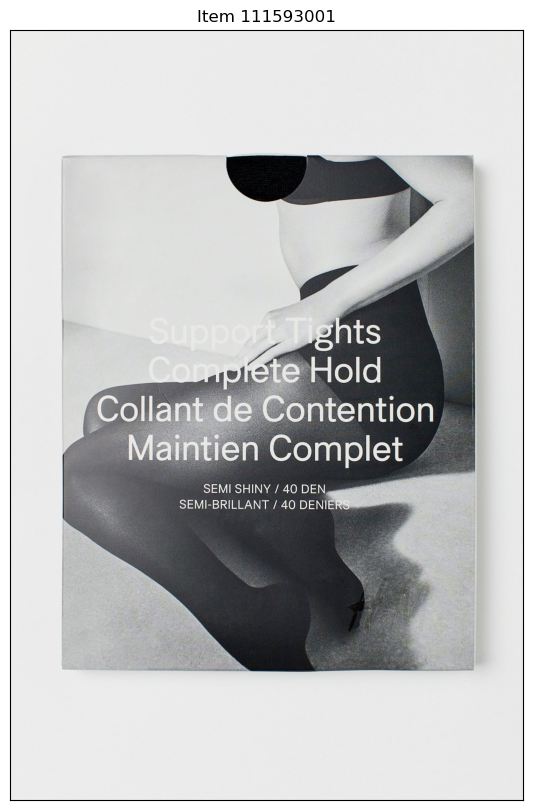


Recommended items for user 25:
- Item 228257004: 20 den 2p Tights with similarity score: 0.7037081718444824
- Item 669091021: ROBIN HOOD. with similarity score: 0.5300108790397644
- Item 556260007: Skinny L.W Elite with similarity score: 0.5272387266159058
- Item 598755001: TAZ LONG RN T-SHIRT with similarity score: 0.5241576433181763
- Item 699424001: Ring Ring Brief with similarity score: 0.52313232421875


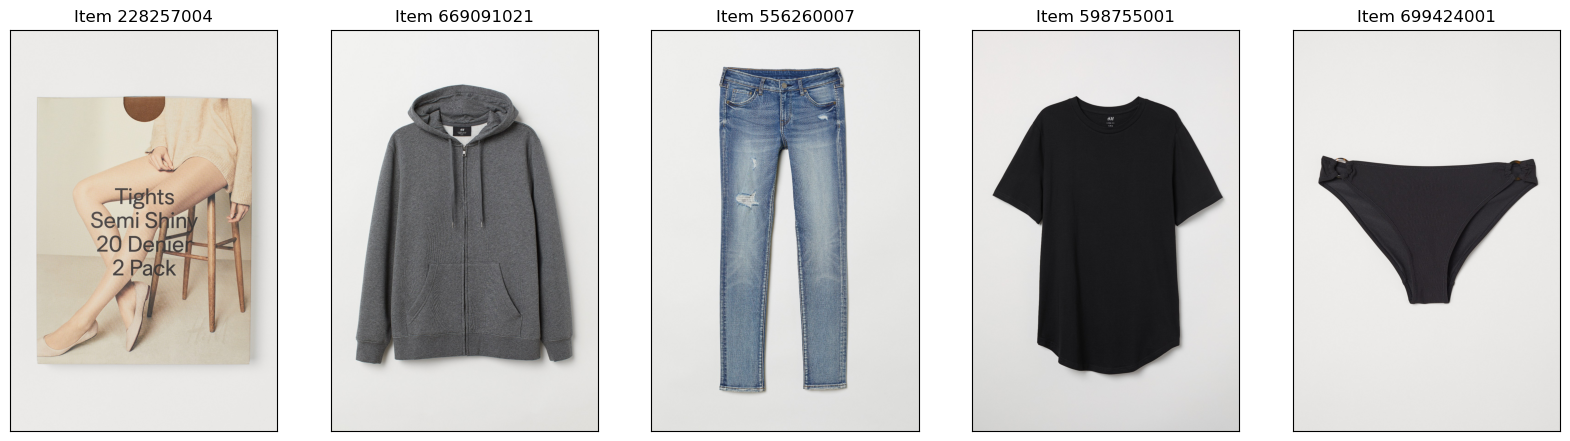

In [ ]:
# costomer 45's top 5
recommend_items(25, GraphTravel_HM, embeddings, item_name_mapping, num_items=5)